In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pyarrow.parquet as pq
from numpy.linalg import norm
import random
import time
from sklearn.svm import SVR

In [2]:
import os

_REP_PATH_ = os.getcwd()

In [3]:
# Initialisation des DataFrames contenant les données

# DataFrame des données d'entrainement
train_df = pd.read_csv(_REP_PATH_+'/data/train_nettoye.csv', index_col = 0)

# DataFrame des données de test
test_df = pd.read_csv(_REP_PATH_+'/data/test_nettoye.csv', index_col = 0)


# Affichage des premiers individus des DataFrames
train_df.head()

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,pickup_hour,dropoff_day,dropoff_hour,journey_time,trip_duration,pickup_period_encoded,airport,PU_in_manhattan,DO_in_manhattan,in_manhattan
0,1.0,3.30,1.0,0,1,19.1,3.5,0.5,4.80,0.0,...,20.616667,15,20.933333,1155.0,1155.0,3,0,1,1,1
1,1.0,0.72,1.0,0,1,5.8,2.5,0.5,2.46,0.0,...,19.683333,25,19.733333,198.0,198.0,2,0,1,1,1
2,2.0,7.45,1.0,0,1,38.7,0.0,0.5,3.00,0.0,...,15.800000,25,16.400000,2135.0,2135.0,1,0,1,1,1
3,1.0,1.53,1.0,0,1,10.0,1.0,0.5,2.25,0.0,...,0.783333,27,0.916667,509.0,509.0,4,0,1,1,1
4,1.0,1.53,1.0,0,1,10.0,0.0,0.5,3.50,0.0,...,13.233333,28,13.366667,488.0,488.0,1,0,1,1,1


In [4]:
test_df.head()

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,...,pickup_hour,dropoff_day,dropoff_hour,journey_time,trip_duration,pickup_period_encoded,airport,PU_in_manhattan,DO_in_manhattan,in_manhattan
row_ID,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.36,1.0,N,1,4.4,0.0,0.5,0.0,1.0,...,8.033333,24,8.066667,118.0,118.0,0,0,1,1,1.0
1,1.0,1.78,1.0,N,1,10.7,0.0,0.5,0.0,1.0,...,14.566667,26,14.700000,473.0,473.0,1,0,1,0,1.0
2,2.0,0.43,1.0,N,2,5.8,0.0,0.5,0.0,1.0,...,15.783333,24,15.850000,261.0,261.0,1,0,1,1,1.0
3,1.0,0.61,1.0,N,1,5.8,0.0,0.5,0.0,1.0,...,14.666667,4,14.733333,244.0,244.0,1,0,1,1,1.0
4,1.0,0.71,1.0,N,2,5.1,1.0,0.5,0.0,1.0,...,5.900000,16,5.916667,116.0,116.0,4,0,1,1,1.0


In [5]:
X_train = train_df[['passenger_count', 'trip_distance', 'RatecodeID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon']]
X_test = test_df[['passenger_count', 'trip_distance', 'RatecodeID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'Airport_fee', 'PU_location_lat', 'PU_location_lon', 'DO_location_lat', 'DO_location_lon']]

Y_train = train_df['tip_amount']

X_train.head()

,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,Airport_fee,PU_location_lat,PU_location_lon,DO_location_lat,DO_location_lon
0,1.0,3.30,1.0,1,19.1,3.5,0.5,0.0,1.0,0.0,40.734576,-74.002875,40.768615,-73.965635
1,1.0,0.72,1.0,1,5.8,2.5,0.5,0.0,1.0,0.0,40.768615,-73.965635,40.780436,-73.957012
2,2.0,7.45,1.0,1,38.7,0.0,0.5,0.0,1.0,0.0,40.717773,-74.007880,40.780436,-73.957012
3,1.0,1.53,1.0,1,10.0,1.0,0.5,0.0,1.0,0.0,40.720889,-73.996919,40.747746,-73.978492
4,1.0,1.53,1.0,1,10.0,0.0,0.5,0.0,1.0,0.0,40.768615,-73.965635,40.747746,-73.978492


# Noyau Polynomial

## On selectionne k=1000 lignes de X_train pour ajuster les hyper_paramètres

In [8]:
indices_selectionnes_train = random.choices(range(len(X_train)), k = 1000)
indices_selectionnes_test = random.choices(range(len(X_train)), k = 1000)
X_train_choice = X_train.to_numpy()[indices_selectionnes_train]
Y_train_choice = Y_train.to_numpy()[indices_selectionnes_train]
X_test_choice = X_train.to_numpy()[indices_selectionnes_test]
Y_test_choice = Y_train.to_numpy()[indices_selectionnes_test]

temps d'exécution  15.396482467651367 8


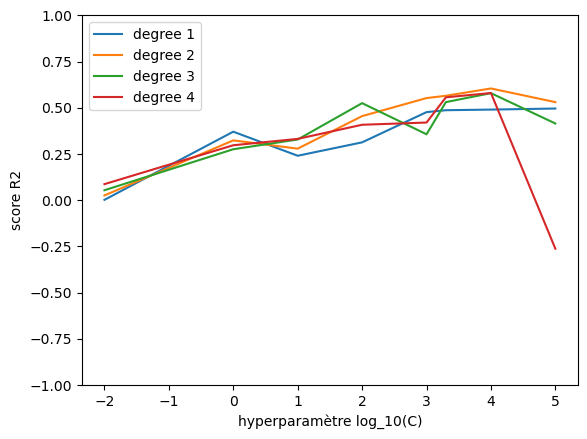

In [9]:
liste_C = [0.01,1,10,10**2,10**3,2*10**3,10**4,10**5]
liste_degree = [1,2,3,4]
tab_r2 = np.zeros((len(liste_degree),len(liste_C)))
start = time.time()
for i in range(len(liste_degree)):
    degree = liste_degree[i]
    for j in range(len(liste_C)):
        C = liste_C[j]
        svr_poly = SVR(kernel='poly', C=C, degree=degree)
        model = svr_poly.fit(X_train_choice,Y_train_choice)
        Y_pred = model.predict(X_test_choice)
        tab_r2[i,j] = r2_score(Y_test_choice, Y_pred)
        print(" dernier effectué : i = " + str(i) + " / " + str(len(liste_degree)) + " j = " + str(j) + " / " + str(len(liste_C)), end = '\r')      
    plt.plot(np.log10(liste_C), tab_r2[i,:], label = 'degree ' + str(degree) )
print("temps d'exécution  " + str(time.time() - start))
plt.legend()
plt.ylim([-1,1])
plt.xlabel("hyperparamètre log_10(C)")
plt.ylabel("score R2")
plt.show()

# Prediction avec Noyau Polynomial de degré 2, C = 10000, k = 10000 lignes de X_train 

In [11]:
indices_selectionnes_train = random.choices(range(len(X_train)), k = 10000)
X_train_reduit = X_train.to_numpy()[indices_selectionnes_train]
Y_train_reduit = Y_train.to_numpy()[indices_selectionnes_train]

In [12]:
C = 10000
degree = 2
start = time.time()
svr_poly = SVR(kernel='poly', C=C, degree=degree)
model = svr_poly.fit(X_train_reduit,Y_train_reduit)
Y_pred = model.predict(X_test.to_numpy())
print("temps d'exécution  " + str(time.time() - start))

temps d'exécution  359.49756145477295


In [13]:
prediction_SVRdegree2 = pd.DataFrame(np.arange(len(Y_pred), dtype = int).T, columns  = ["row_ID"])
prediction_SVRdegree2["tip_amount"] = Y_pred
prediction_SVRdegree2.to_parquet(_REP_PATH_ + "/output/prediction_SVRdegree2.parquet")

Score R2 : entre 0.56417 et 0.60196 selon les indices sélectionnés aléatoirement pour l'entraînement.

# Prediction avec Noyau Polynomial de degré 3, C = 100, k = 10000 lignes de X_train 

In [16]:
indices_selectionnes_train = random.choices(range(len(X_train)), k = 10000)
X_train_reduit = X_train.to_numpy()[indices_selectionnes_train]
Y_train_reduit = Y_train.to_numpy()[indices_selectionnes_train]

In [17]:
C = 100
degree = 3
start = time.time()
svr_poly = SVR(kernel='poly', C=C, degree=degree)
model = svr_poly.fit(X_train_reduit,Y_train_reduit)
Y_pred = model.predict(X_test.to_numpy())
print("temps d'exécution  " + str(time.time() - start))
# 32 sec pour k = 1000
# 300 sec pour k = 10 000
# 3700 sec pour X_train entier

temps d'exécution  399.9987823963165


In [18]:
prediction_SVRdegree3 = pd.DataFrame(np.arange(len(Y_pred), dtype = int).T, columns  = ["row_ID"])
prediction_SVRdegree3["tip_amount"] = Y_pred
prediction_SVRdegree3.to_parquet(_REP_PATH_ + "/output/prediction_SVRdegree3.parquet")

Score R2 : entre -1.46966 et 0.34553 selon les indices sélectionnés aléatoirement pour l'entraînement.

On retiendra le modèle obtenu à l'aide du jeu tronqué (k = 10000) et le noyau polynomial de degré 2

# Noyau Gaussien codé à la main

Le noyau gaussien ne sera pas retenu car trop long en temps d'exécution et offrant des résultats trop mauvais. Voici tout de même les codes testés :

In [24]:
# def optimise_alpha(X, Y, Kernel, lbda=1):
#     # On transforme nos DataFrame en matrices numpy
#     if type(X) == pd.core.frame.DataFrame:
#         X = X.to_numpy()
#     if type(Y) == pd.core.frame.DataFrame:
#         Y = Y.to_numpy()
        
#     K = np.array([ [Kernel_gauss(x1,x2) for x2 in X] for x1 in X]) 
#     n = len(X)
#     alpha = np.linalg.inv(K + len(X)*lbda*np.eye(len(X)))@Y
#     return alpha

# def predicteur(Kernel, alpha, X_connu, x_predict):
#     K_Xx = np.array([Kernel(x, x_predict) for x in X_connu])
#     return alpha@K_Xx

# indices_selectionnes_train = random.choices(range(len(X_train)), k = 1000)
# indices_selectionnes_test = random.choices(range(len(X_train)), k = 1000)
# X_train_choice = X_train.to_numpy()[indices_selectionnes_train]
# Y_train_choice = Y_train.to_numpy()[indices_selectionnes_train]
# X_test_choice = X_train.to_numpy()[indices_selectionnes_test]
# Y_test_choice = Y_train.to_numpy()[indices_selectionnes_test]

# liste_var = [1,10,np.var(Y_train_choice), 20, 30, 40,60,80,200,400,1000,10000]
# liste_lbda = [0.00001,0.0001,0.001,0.1,1,2]
# liste_lbda = np.linspace(0,0.1,10) # liste_lbda est un tableau
# tab_r2_lbda = np.zeros((len(liste_var), len(liste_lbda)))
# start = time.time()

# for i in range(len(liste_var)):
#     var = liste_var[i]
#     def Kernel_gauss(x1,x2, sigma2=var):
#         return np.exp(-norm(x1-x2)**2/(2*sigma2))
#     for j in range(len(liste_lbda)):
#         lbda = liste_lbda[j]
#         try :
#             alpha = optimise_alpha(X_train_choice, Y_train_choice, Kernel_gauss, lbda = lbda)
#             Y_pred = [predicteur2(Kernel_gauss, alpha, X_train_choice, x_test) for x_test in X_test_choice]
#             tab_r2_lbda[i,j] = r2_score(Y_test_choice, Y_pred)
#         except : 
#             tab_r2_lbda[i,j] = -1000
#         print(" dernier effectué : i = " + str(i) + " / " + str(len(liste_var)) + "   j = " + str(j) + " / " + str(len(liste_lbda)), end = '\r')
#     plt.plot(liste_lbda,tab_r2_lbda[i,:], label = 'var = ' +str(var))
# print("temps d'exécution  " + str(time.time() - start))
# plt.legend()
# plt.ylim([-1,1])
# plt.xlabel("lambda")
# plt.ylabel("score R2")
# plt.show()